# Predicting Cement Compressive Strength Using Linear Regression Model
With the data explored, and familiarized from the previous [notebook](./01%20-%20About%20the%20Dataset.ipynb), we are now ready to conduct build a model to predict the compressive strenght of a cement.

## Pre-processing
As we have discovered from the previous notebook, the features of our dataset were highly skewed. In this section, we will conduct several data pre-processing to our dataset so that we can enable our model to learn effectively and efficiently.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use(['science', 'notebook'])

In [2]:
DATASET_URI = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"

dataset = pd.read_excel(DATASET_URI)

# Replace the Headers for Readability
attributes = [
  "Cement", "Blast Furnace Slag", "Fly Ash", "Water", "Superplasticizer",
  "Coarse Aggregate", "Fine Aggregate", "Age", "Concrete Compressive Strength"
]

dataset.columns = attributes

### Creating Training, Validation, and Test Set
Before we proceed to any pre-processing and modelling, let's split our dataset into three parts.
1. Training Set - To be used during training.
2. Validation Set - To be used during cross validation after training with the purpose of detecting bias/variance from training.
3. Test Set - To be used for evaluating our model.

In [3]:
from sklearn.model_selection import train_test_split

X = dataset.iloc[:,0:-1]
y = dataset.iloc[:, -1]

# Split the dataset into 80% training set, and 20% cross validation + test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Split the cross validation + test set from previous split and split them equally
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

### Scaling the Features
Now, lets scale our features, we will train the standard scaler from the training set and use this scaler to validation, and test set.

In [4]:
from sklearn.preprocessing import StandardScaler
# Instanciate the Standard Scaler
std_scaler = StandardScaler()

# Train the scaler on the training set only
std_scaler.fit(X_train.values)

# Transform each splits into a standard scale
scaled_X_train = std_scaler.transform(X_train.values)
scaled_X_val = std_scaler.transform(X_val.values)
scaled_X_test = std_scaler.transform(X_test.values)

[Text(0.5, 1.0, 'Scaled Training Set')]

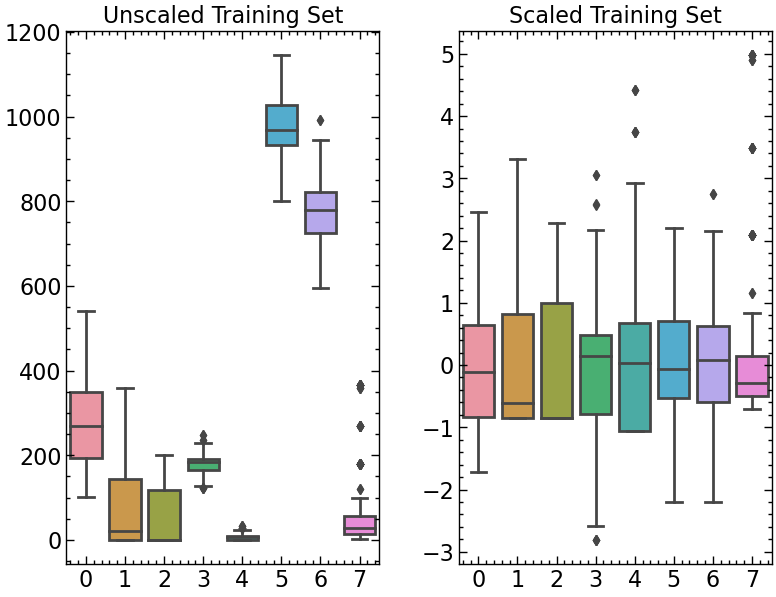

In [5]:
figure, axes = plt.subplots(1,2)
figure.tight_layout()

sns.boxplot(X_train.to_numpy(), ax=axes[0]).set(title="Unscaled Training Set")
sns.boxplot(scaled_X_train, ax=axes[1]).set(title="Scaled Training Set")

[Text(0.5, 1.0, 'Scaled Validation Set')]

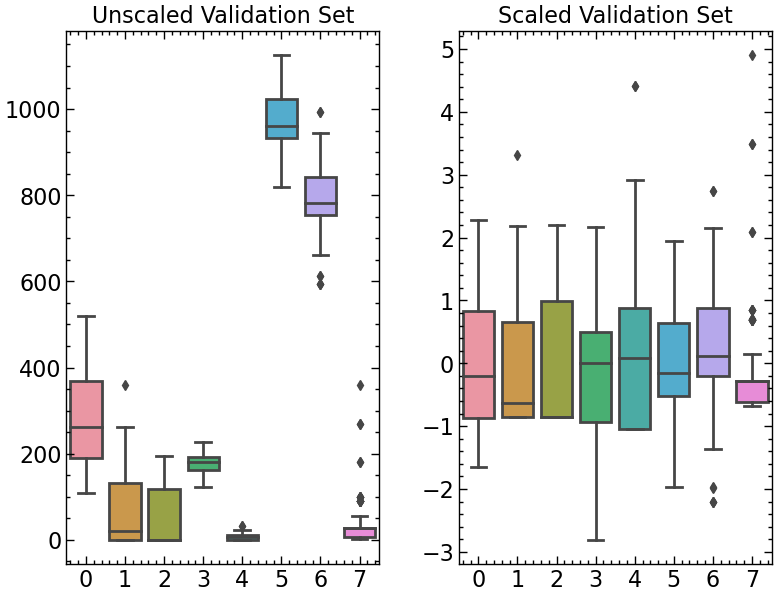

In [6]:
figure, axes = plt.subplots(1, 2)
figure.tight_layout()

sns.boxplot(X_val.to_numpy(), ax=axes[0]).set(title="Unscaled Validation Set")
sns.boxplot(scaled_X_val, ax=axes[1]).set(title="Scaled Validation Set")

[Text(0.5, 1.0, 'Scaled Test Set')]

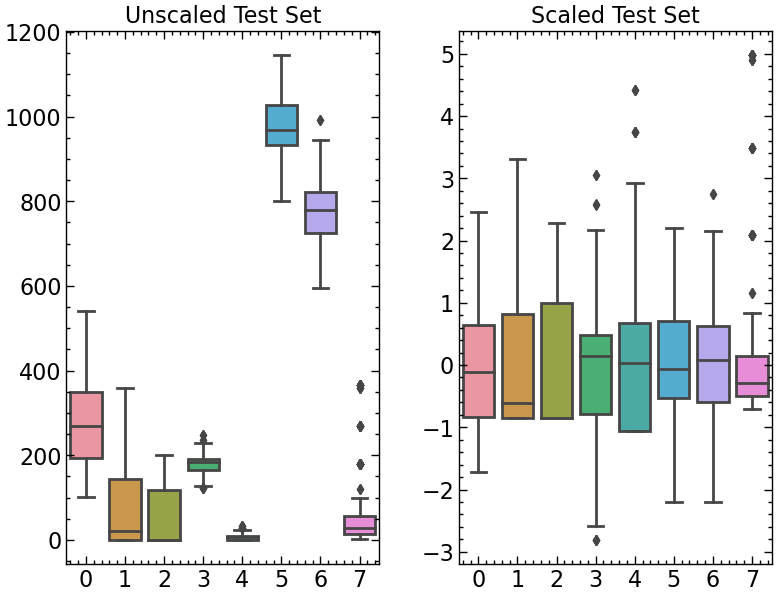

In [7]:
figure, axes = plt.subplots(1, 2)
figure.tight_layout()

sns.boxplot(X_train.to_numpy(), ax=axes[0]).set(title="Unscaled Test Set")
sns.boxplot(scaled_X_train, ax=axes[1]).set(title="Scaled Test Set")

#### The Dataset Is Now Ready
With scaled features, our dataset is not very skewed and is now ready for modelling.

## OLS Regression: Linear Regression
Now lets start conducting linear regression, we will begin with the most simple Linear regression, then we will try using different degrees of polynomial features, and finally we will apply regularization to minimize overfitting.

In [8]:
from sklearn.linear_model import LinearRegression

# Fit the model to our training set
linear_regression = LinearRegression()
linear_regression.fit(scaled_X_train, y_train.values)

# Predict compressive strength from each split
y_train_pred = linear_regression.predict(scaled_X_train)
y_val_pred = linear_regression.predict(scaled_X_val)
y_test_pred = linear_regression.predict(scaled_X_test)

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

split_pairs = [
  (y_train, y_train_pred),
  (y_val, y_val_pred),
  (y_test, y_test_pred)
]

MAE  = []
MSE  = []
RMSE = []

for pair in split_pairs:
  MAE.append(mean_absolute_error(pair[0], pair[1]))
  MSE.append(mean_squared_error(pair[0], pair[1]))
  RMSE.append(mean_squared_error(pair[0], pair[1], squared=False))

linear_regression_errors = pd.DataFrame({
  "Error Type": ["Training Error", "Validation Error", "Testing Error"],
  "MAE (in Mega-Pascals)": MAE,
  "MSE(in Mega-Pascals)^2": MSE,
  "RMSE (in Mega-Pascals)": RMSE
})
linear_regression_errors

,Error Type,MAE (in Mega-Pascals),MSE(in Mega-Pascals)^2,RMSE (in Mega-Pascals)
0,Training Error,8.037219,104.701221,10.232361
1,Validation Error,8.155582,96.271840,9.811821
2,Testing Error,9.782676,141.304387,11.887152


### Results
Our training, validation and test errors were almost near  at each other. This might be an indicator that our model is not overfitting. However, our loss is still large. On the next section, we will try to use polynomial features and see if we can improve our linear model.

## OLS Regression: Linear Regression with Polynomial Features
Now, let's improve our model by adding polynomial features, we will evaluate which polynomial degree will minimize the loss and overfitting.

In [10]:
from sklearn.preprocessing import PolynomialFeatures

MAE_train = []
MSE_train = []
RMSE_train = []

MAE_val = []
MSE_val = []
RMSE_val = []

MAE_test = []
MSE_test = []
RMSE_test = []

degrees = range(1, 11)

for degree in degrees:
  poly_features = PolynomialFeatures(degree=degree)
  linear_regression = LinearRegression()

  # Create polynomial features for each input splits
  scaled_X_train_poly = poly_features.fit_transform(scaled_X_train)
  scaled_X_val_poly = poly_features.fit_transform(scaled_X_val)
  scaled_X_test_poly = poly_features.fit_transform(scaled_X_test)

  # Fit the training data with polynomial features
  linear_regression.fit(scaled_X_train_poly, y_train)

  # Predict compressive strength from each split
  y_train_pred = linear_regression.predict(scaled_X_train_poly)
  y_val_pred = linear_regression.predict(scaled_X_val_poly)
  y_test_pred = linear_regression.predict(scaled_X_test_poly)

  MAE_train.append(mean_absolute_error(y_train, y_train_pred))
  MSE_train.append(mean_squared_error(y_train, y_train_pred))
  RMSE_train.append(mean_squared_error(y_train, y_train_pred, squared=False))

  MAE_val.append(mean_absolute_error(y_val, y_val_pred))
  MSE_val.append(mean_squared_error(y_val, y_val_pred))
  RMSE_val.append(mean_squared_error(y_val, y_val_pred, squared=False))

  MAE_test.append(mean_absolute_error(y_test, y_test_pred))
  MSE_test.append(mean_squared_error(y_test, y_test_pred))
  RMSE_test.append(mean_squared_error(y_test, y_test_pred, squared=False))

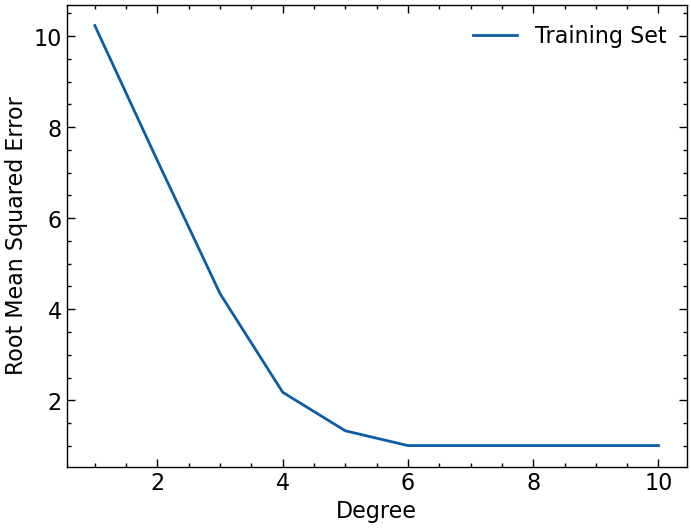

In [11]:
plt.plot(degrees, RMSE_train, label="Training Set")
plt.xlabel("Degree")
plt.ylabel("Root Mean Squared Error")
plt.legend()

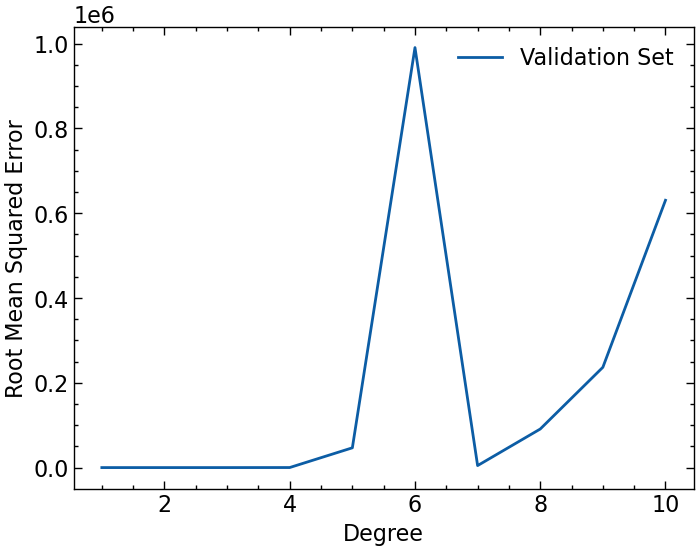

In [12]:
plt.plot(degrees, RMSE_val, label="Validation Set")
plt.xlabel("Degree")
plt.ylabel("Root Mean Squared Error")
plt.legend()


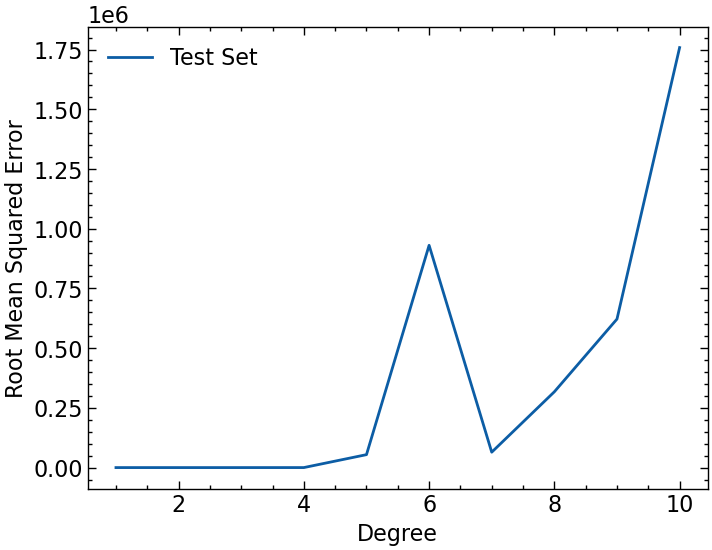

In [13]:
plt.plot(degrees, RMSE_test, label="Test Set")
plt.xlabel("Degree")
plt.ylabel("Root Mean Squared Error")
plt.legend()


## Selected Degree
The following code snippet below will display the degrees which returns a minimum RMSE per dataset split.

In [14]:
min_degree_train = np.argmin(RMSE_train) + 1
min_degree_val = np.argmin(RMSE_val) + 1
min_degree_test = np.argmin(RMSE_test) + 1

print(f"Degree with Minimum Training RMSE: {min_degree_train}")
print(f"Degree with Minimum Validation RMSE: {min_degree_val}")
print(f"Degree with Minimum Testing RMSE: {min_degree_test}")


Degree with Minimum Training RMSE: 7
Degree with Minimum Validation RMSE: 2
Degree with Minimum Testing RMSE: 3


Based on the results, we can attain minimum training error when we use 8th degree polynomial features, however we will be encountering overfitting as the RMSE on the validation and testing set were significantly higher especially at 4th degree. Thus we will be using the 3rd degree polynomial features.

In [15]:
poly_features = PolynomialFeatures(degree=3)
linear_regression = LinearRegression()

# Create polynomial features for each input splits
scaled_X_train_poly = poly_features.fit_transform(scaled_X_train)
scaled_X_val_poly = poly_features.fit_transform(scaled_X_val)
scaled_X_test_poly = poly_features.fit_transform(scaled_X_test)

# Fit the training data with polynomial features
linear_regression.fit(scaled_X_train_poly, y_train)

# Predict compressive strength from each split
y_train_pred = linear_regression.predict(scaled_X_train_poly)
y_val_pred = linear_regression.predict(scaled_X_val_poly)
y_test_pred = linear_regression.predict(scaled_X_test_poly)

split_pairs = [
    (y_train, y_train_pred),
    (y_val, y_val_pred),
    (y_test, y_test_pred)
]

MAE = []
MSE = []
RMSE = []

for pair in split_pairs:
  MAE.append(mean_absolute_error(pair[0], pair[1]))
  MSE.append(mean_squared_error(pair[0], pair[1]))
  RMSE.append(mean_squared_error(pair[0], pair[1], squared=False))

linear_regression_with_poly_features_errors = pd.DataFrame({
    "Error Type": ["Training Error", "Validation Error", "Testing Error"],
    "MAE (in Mega-Pascals)": MAE,
    "MSE(in Mega-Pascals)^2": MSE,
    "RMSE (in Mega-Pascals)": RMSE
})
linear_regression_with_poly_features_errors

,Error Type,MAE (in Mega-Pascals),MSE(in Mega-Pascals)^2,RMSE (in Mega-Pascals)
0,Training Error,3.333588,18.842223,4.340763
1,Validation Error,5.301488,95.677762,9.781501
2,Testing Error,5.036891,48.413525,6.957983


## Comparing Results
Now, lets compare our new-found model with the previous one.

In [16]:
change_MAE = linear_regression_with_poly_features_errors["MAE (in Mega-Pascals)"] / linear_regression_errors["MAE (in Mega-Pascals)"] - 1
change_MSE = linear_regression_with_poly_features_errors["MSE(in Mega-Pascals)^2"] / linear_regression_errors["MSE(in Mega-Pascals)^2"] - 1
change_RMSE = linear_regression_with_poly_features_errors["RMSE (in Mega-Pascals)"] / linear_regression_errors["RMSE (in Mega-Pascals)"] - 1

In [17]:
changes = pd.DataFrame({
  "Split": ["Training Set", "Validation Set", "Testing Set"],
  "MAE(% Change)": change_MAE,
  "MSE(% Change)": change_MSE,
  "RMSE(% Change)": change_RMSE,
})
changes

,Split,MAE(% Change),MSE(% Change),RMSE(% Change)
0,Training Set,-0.585231,-0.820038,-0.575781
1,Validation Set,-0.349956,-0.006171,-0.003090
2,Testing Set,-0.485121,-0.657381,-0.414664


## Improvements
Overall, using 3rd degree polynomial features on linear regression greatly improves the error on training set by 58.49%, 21.85% on validation set, and 42.52% on test set.

can we still improve these prediction errors? in the next section, we will be trying to apply regularization techniques to further improve our model.